In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.integrate import odeint

np.random.seed(42)
torch.manual_seed(42)

## Generating Synthetic Datset for 2D Burgers equation

In [3]:
def burgers_2d_analytical(x, y, t, nu):
    
    u = np.sin(np.pi * x) * np.sin(np.pi * y) * np.exp(-2 * nu * np.pi**2 * t)
    v = np.cos(np.pi * x) * np.cos(np.pi * y) * np.exp(-2 * nu * np.pi**2 * t)
    return u, v

def generate_burgers_2d_dataset(nu_values, nx=50, ny=50, nt=50, 
                                 x_range=(0, 1), y_range=(0, 1), t_range=(0, 1)):
    
    x = np.linspace(x_range[0], x_range[1], nx)
    y = np.linspace(y_range[0], y_range[1], ny)
    t = np.linspace(t_range[0], t_range[1], nt)
    
    X, Y, T = np.meshgrid(x, y, t, indexing='ij')
    
    datasets = {}
    
    for nu in nu_values:
        U, V = burgers_2d_analytical(X, Y, T, nu)
        
        
        x_flat = X.flatten()
        y_flat = Y.flatten()
        t_flat = T.flatten()
        u_flat = U.flatten()
        v_flat = V.flatten()
        
        datasets[nu] = {
            'x': x_flat,
            'y': y_flat,
            't': t_flat,
            'u': u_flat,
            'v': v_flat,
            'X': X,
            'Y': Y,
            'T': T,
            'U': U,
            'V': V,
            'nu': nu
        }
    
    return datasets, x, y, t


In [10]:
all_nu_values = [0.01, 0.02, 0.05, 0.1]
    
datasets, x, y, t = generate_burgers_2d_dataset(
    nu_values=all_nu_values,
    nx=40,
    ny=40,
    nt=40,
    x_range=(0, 1),
    y_range=(0, 1),
    t_range=(0, 1)
)

## Visualizing of patterns 

In [5]:
def visualize_burgers_patterns(datasets, x, y, t, save_prefix='burgers'):

    fig, axes = plt.subplots(len(datasets), 3, figsize=(18, 6*len(datasets)))
    
    if len(datasets) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (nu, data) in enumerate(datasets.items()):
        t_idx = len(t) // 2
        
        U_snapshot = data['U'][:, :, t_idx]
        V_snapshot = data['V'][:, :, t_idx]
        magnitude = np.sqrt(U_snapshot**2 + V_snapshot**2)
        
        # Plotting the U velocity
        im1 = axes[idx, 0].contourf(x, y, U_snapshot.T, levels=20, cmap='RdBu_r')
        axes[idx, 0].set_title(f'U velocity (ν={nu}, t={t[t_idx]:.2f})')
        axes[idx, 0].set_xlabel('x')
        axes[idx, 0].set_ylabel('y')
        plt.colorbar(im1, ax=axes[idx, 0])
        
        # Plotting the V velocity
        im2 = axes[idx, 1].contourf(x, y, V_snapshot.T, levels=20, cmap='RdBu_r')
        axes[idx, 1].set_title(f'V velocity (ν={nu}, t={t[t_idx]:.2f})')
        axes[idx, 1].set_xlabel('x')
        axes[idx, 1].set_ylabel('y')
        plt.colorbar(im2, ax=axes[idx, 1])
        
        im3 = axes[idx, 2].contourf(x, y, magnitude.T, levels=20, cmap='viridis')
        
        skip = 5
        axes[idx, 2].quiver(x[::skip], y[::skip], 
                           U_snapshot[::skip, ::skip].T, 
                           V_snapshot[::skip, ::skip].T,
                           color='white', alpha=0.6)
        axes[idx, 2].set_title(f'Velocity Magnitude (ν={nu})')
        axes[idx, 2].set_xlabel('x')
        axes[idx, 2].set_ylabel('y')
        plt.colorbar(im3, ax=axes[idx, 2])
    
    plt.tight_layout()
    plt.savefig(f'{save_prefix}_patterns.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    for nu, data in datasets.items():
        print(f"\nViscosity ν = {nu}:")
        print(f"  - Higher viscosity → More diffusion, smoother patterns")
        print(f"  - U velocity range: [{data['u'].min():.4f}, {data['u'].max():.4f}]")
        print(f"  - V velocity range: [{data['v'].min():.4f}, {data['v'].max():.4f}]")
        

def visualize_time_evolution(data, x, y, t, nu, save_prefix='evolution'):
    time_indices = [0, len(t)//4, len(t)//2, 3*len(t)//4, -1]
    
    fig, axes = plt.subplots(2, len(time_indices), figsize=(20, 8))
    
    for idx, t_idx in enumerate(time_indices):
        U_snapshot = data['U'][:, :, t_idx]
        V_snapshot = data['V'][:, :, t_idx]
        
        im1 = axes[0, idx].contourf(x, y, U_snapshot.T, levels=20, cmap='RdBu_r')
        axes[0, idx].set_title(f't={t[t_idx]:.3f}')
        axes[0, idx].set_xlabel('x')
        axes[0, idx].set_ylabel('y')
        plt.colorbar(im1, ax=axes[0, idx])
        
        im2 = axes[1, idx].contourf(x, y, V_snapshot.T, levels=20, cmap='RdBu_r')
        axes[1, idx].set_xlabel('x')
        axes[1, idx].set_ylabel('y')
        plt.colorbar(im2, ax=axes[1, idx])
    
    axes[0, 0].set_ylabel('U velocity\ny', fontsize=12)
    axes[1, 0].set_ylabel('V velocity\ny', fontsize=12)
    
    plt.suptitle(f'Time Evolution of 2D Burgers\' Equation (ν={nu})', fontsize=14, y=1.02)
    plt.tight_layout()
    
    plt.show()

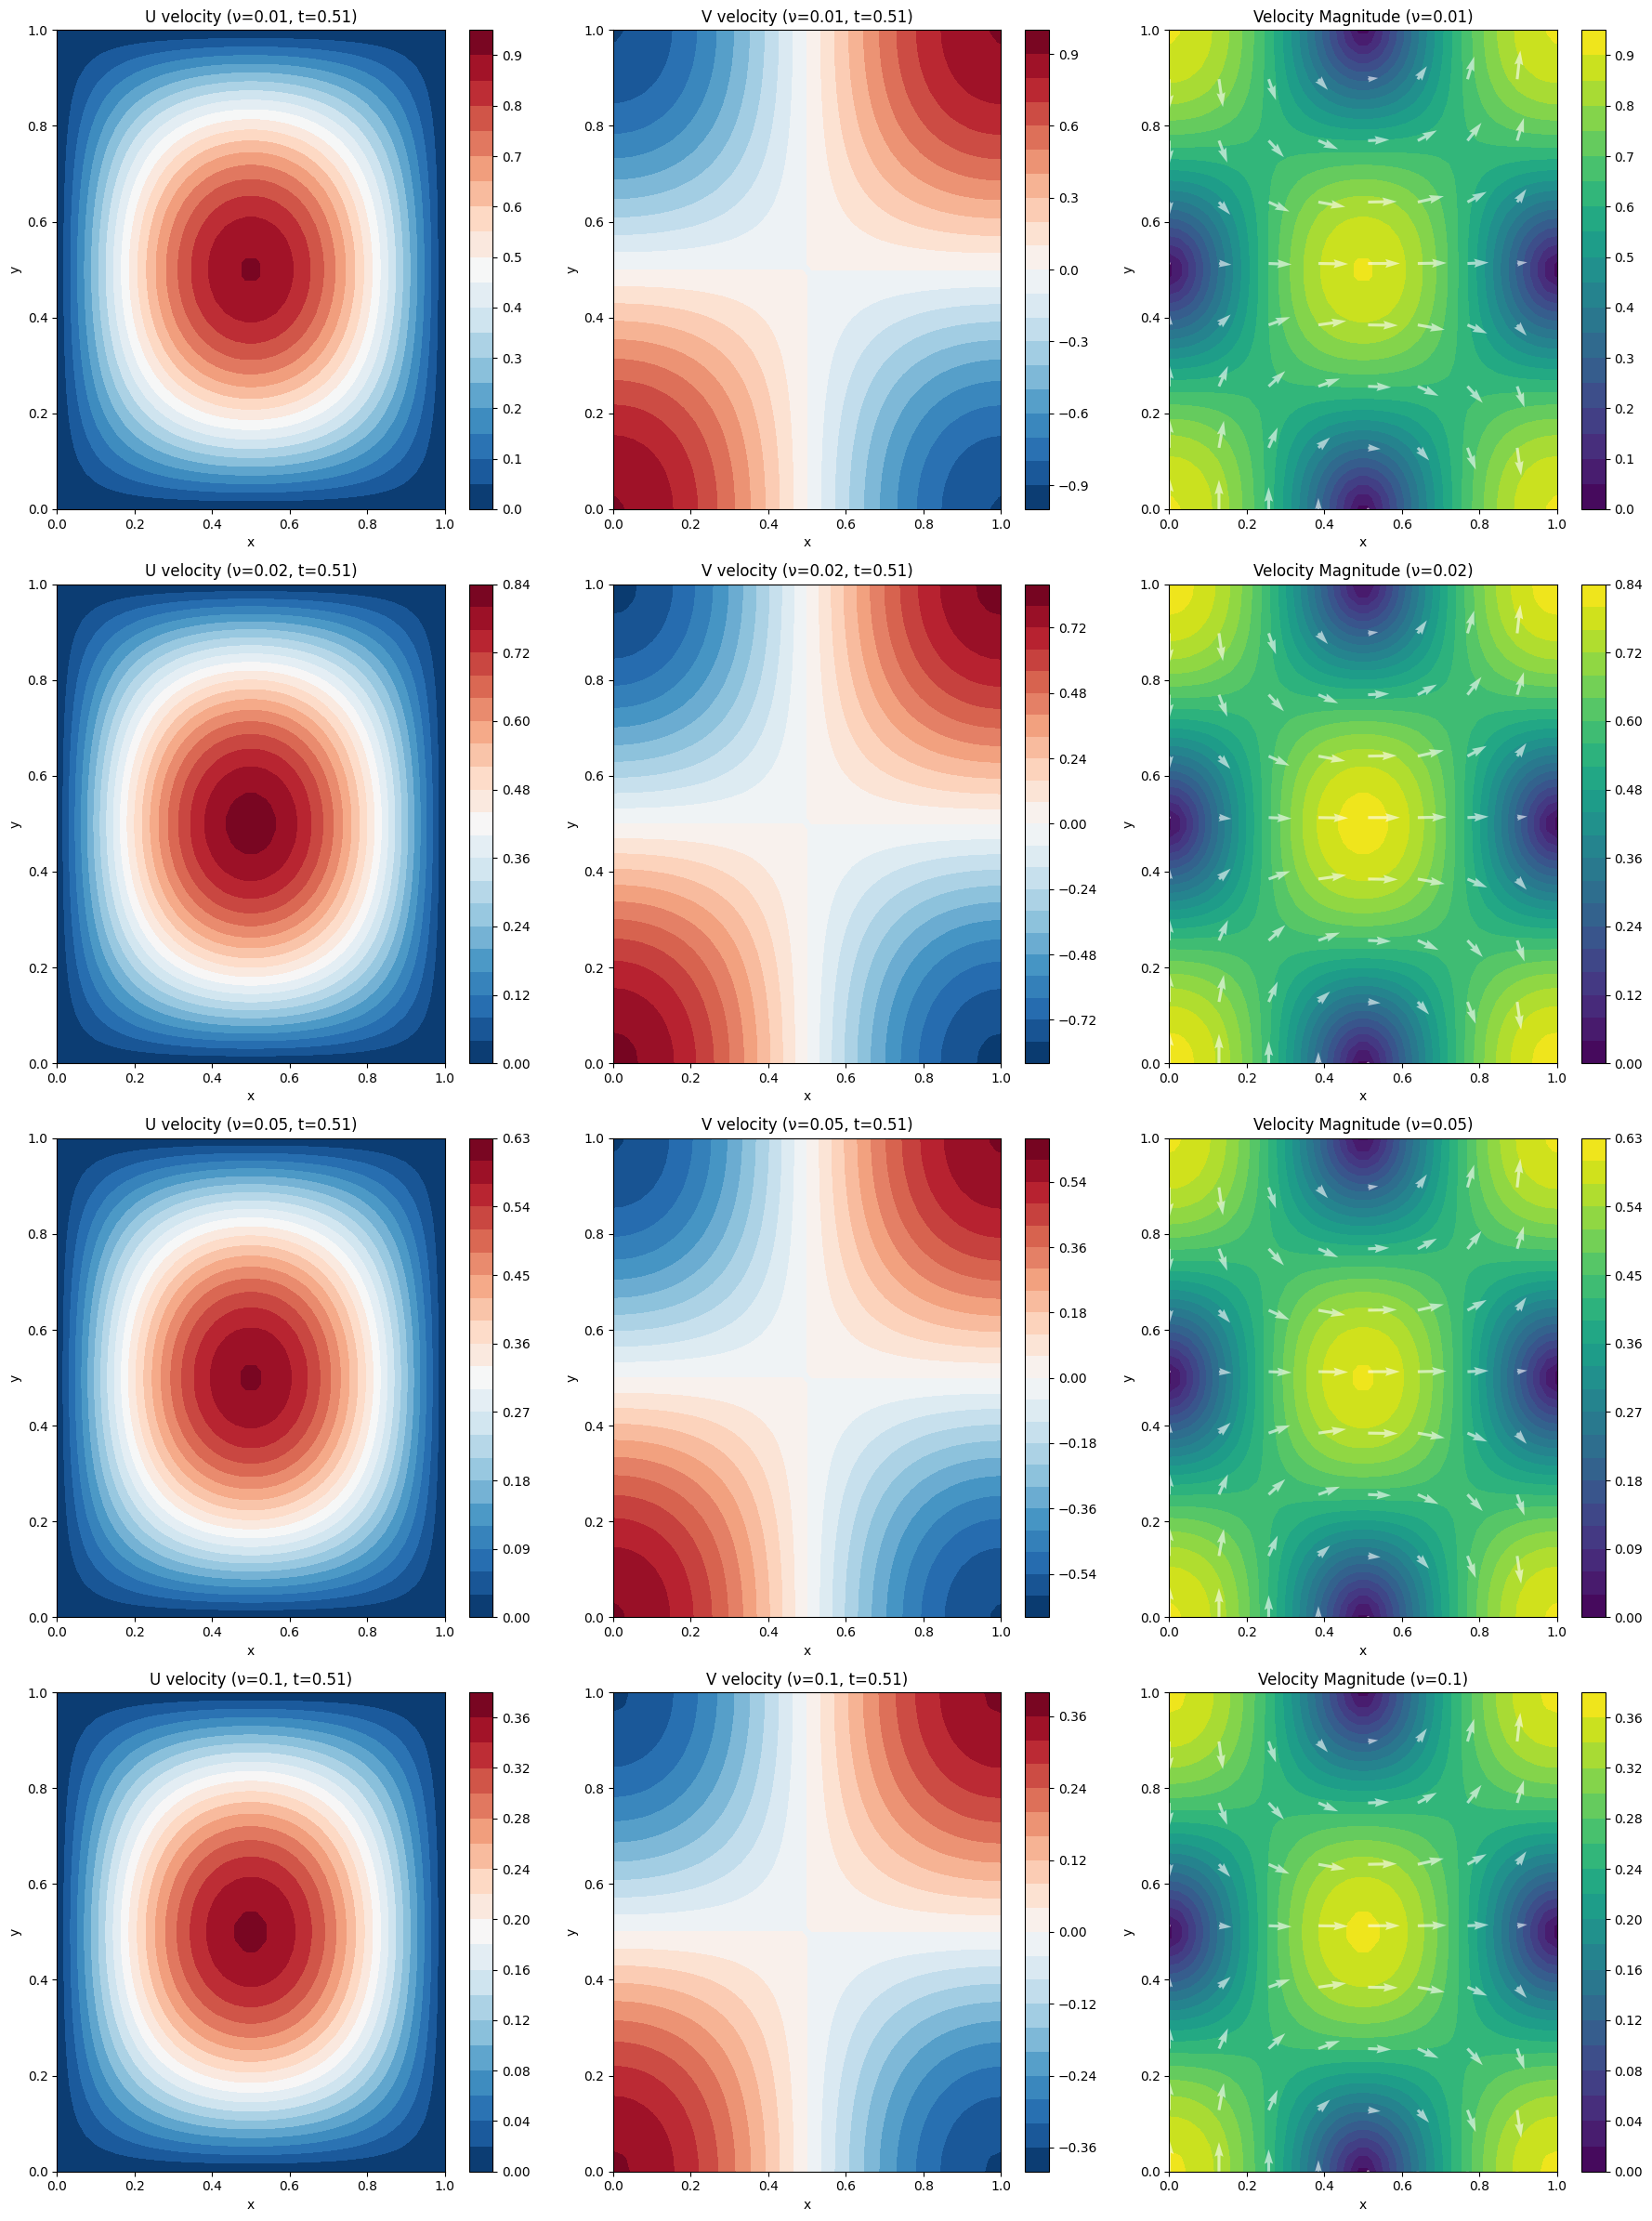


Viscosity ν = 0.01:
  - Higher viscosity → More diffusion, smoother patterns
  - U velocity range: [0.0000, 0.9984]
  - V velocity range: [-1.0000, 1.0000]

Viscosity ν = 0.02:
  - Higher viscosity → More diffusion, smoother patterns
  - U velocity range: [0.0000, 0.9984]
  - V velocity range: [-1.0000, 1.0000]

Viscosity ν = 0.05:
  - Higher viscosity → More diffusion, smoother patterns
  - U velocity range: [0.0000, 0.9984]
  - V velocity range: [-1.0000, 1.0000]

Viscosity ν = 0.1:
  - Higher viscosity → More diffusion, smoother patterns
  - U velocity range: [0.0000, 0.9984]
  - V velocity range: [-1.0000, 1.0000]


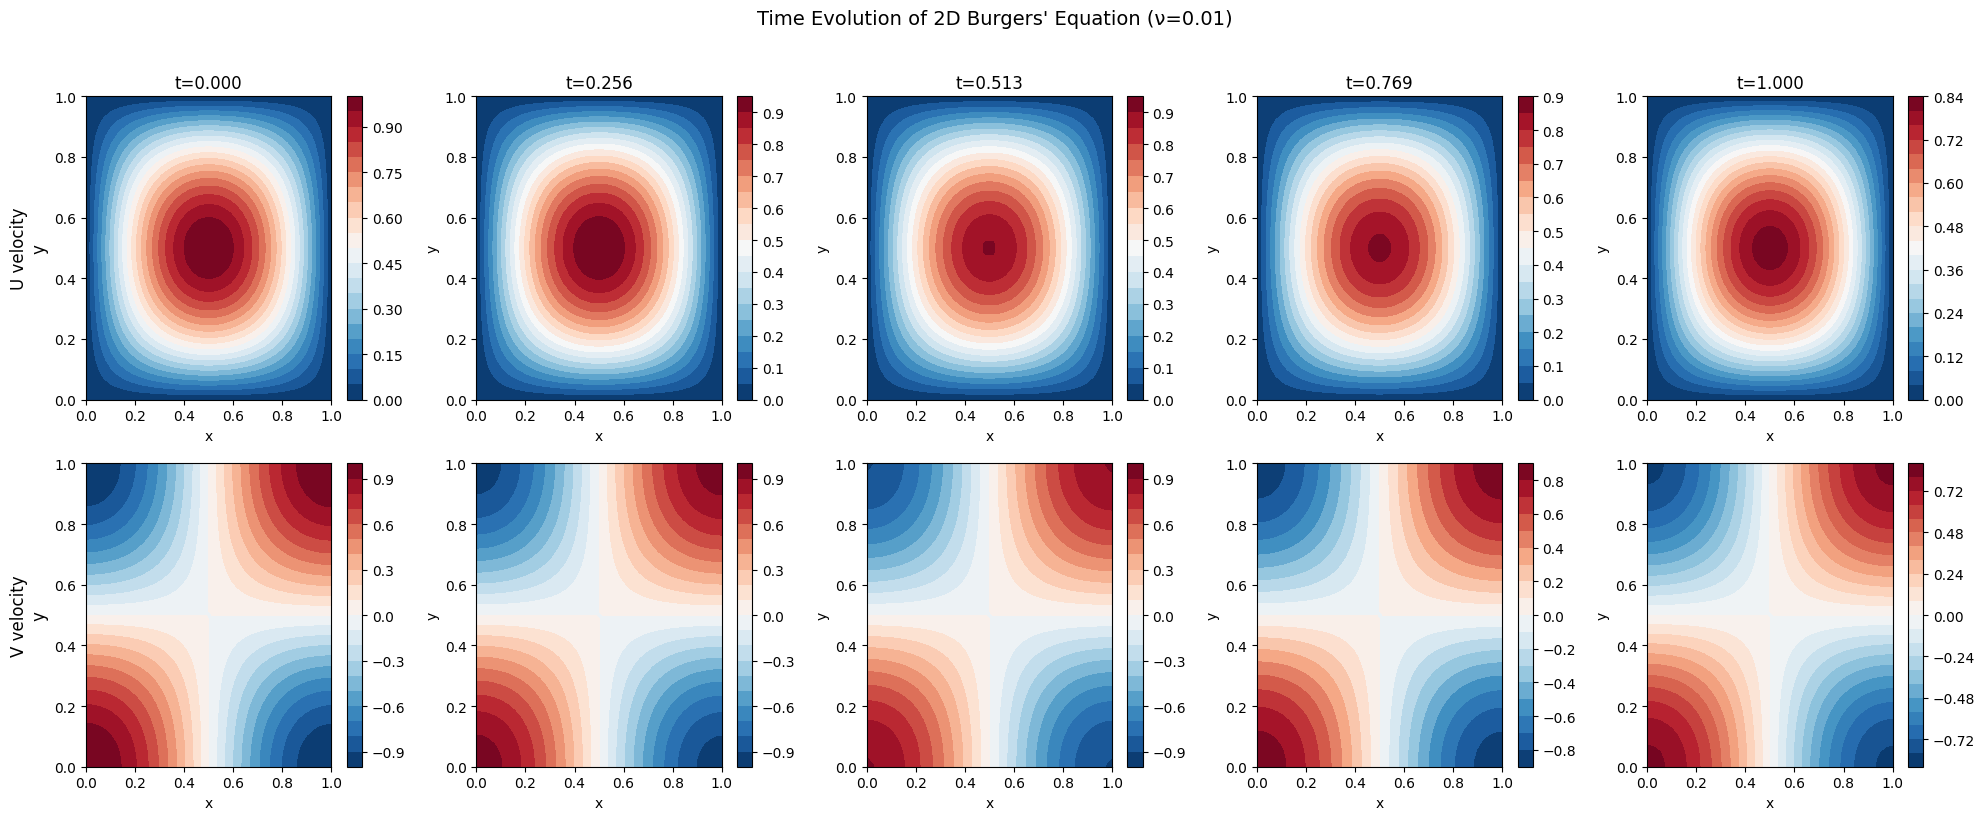

In [9]:
visualize_burgers_patterns(datasets, x, y, t, save_prefix='burgers')
    
visualize_time_evolution(datasets[0.01], x, y, t, nu=0.01, save_prefix='evolution')

## Train-Test Splitting

In [13]:
def create_grouped_split(datasets, train_nu_values, test_nu_values, sample_fraction=0.3):

    train_data = {'x': [], 'y': [], 't': [], 'u': [], 'v': [], 'nu': []}
    test_data = {'x': [], 'y': [], 't': [], 'u': [], 'v': [], 'nu': []}
    
    for nu in train_nu_values:
        data = datasets[nu]
        n_samples = len(data['x'])
        n_selected = int(n_samples * sample_fraction)
        
        indices = np.random.choice(n_samples, n_selected, replace=False)
        
        train_data['x'].append(data['x'][indices])
        train_data['y'].append(data['y'][indices])
        train_data['t'].append(data['t'][indices])
        train_data['u'].append(data['u'][indices])
        train_data['v'].append(data['v'][indices])
        train_data['nu'].append(np.full(n_selected, nu))
    
    for nu in test_nu_values:
        data = datasets[nu]
        n_samples = len(data['x'])
        n_selected = int(n_samples * sample_fraction)
        
        indices = np.random.choice(n_samples, n_selected, replace=False)
        
        test_data['x'].append(data['x'][indices])
        test_data['y'].append(data['y'][indices])
        test_data['t'].append(data['t'][indices])
        test_data['u'].append(data['u'][indices])
        test_data['v'].append(data['v'][indices])
        test_data['nu'].append(np.full(n_selected, nu))
    
    for key in train_data.keys():
        train_data[key] = np.concatenate(train_data[key])
        test_data[key] = np.concatenate(test_data[key])
    
    print(f"\nData Split Summary")
    print(f"Training nu values: {train_nu_values}")
    print(f"Testing nu values: {test_nu_values}")
    print(f"Training samples: {len(train_data['x'])}")
    print(f"Testing samples: {len(test_data['x'])}")
    
    return train_data, test_data


In [14]:
train_nu_values = [0.01, 0.05]  
test_nu_values = [0.02, 0.1]    
train_data, test_data = create_grouped_split(
datasets,
train_nu_values=train_nu_values,
test_nu_values=test_nu_values,
sample_fraction=0.3
)


Data Split Summary
Training nu values: [0.01, 0.05]
Testing nu values: [0.02, 0.1]
Training samples: 38400
Testing samples: 38400


## Defining the NN

In [15]:
class BurgersPINN(nn.Module):
    def __init__(self, hidden_layers=[50, 50, 50, 50], activation='tanh'):
        super(BurgersPINN, self).__init__()
        
        layers = []
        input_dim = 4
        
        layers.append(nn.Linear(input_dim, hidden_layers[0]))
        
        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
    
        layers.append(nn.Linear(hidden_layers[-1], 2))
        
        self.layers = nn.ModuleList(layers)
        
        if activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            self.activation = nn.Tanh()
        
        self.init_weights()
    
    def init_weights(self):
        for m in self.layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
    
    def forward(self, x, y, t, nu):
        inputs = torch.cat([x, y, t, nu], dim=1)
        
        out = inputs
        for i, layer in enumerate(self.layers[:-1]):
            out = self.activation(layer(out))

        out = self.layers[-1](out)
        
        u = out[:, 0:1]
        v = out[:, 1:2]
        
        return u, v


## Helper for Automatic Differentiation: 
### This will return Dictionary containing all required derivatives

In [18]:
def compute_derivatives(u, v, x, y, t):
    
    # First derivatives
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                               create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u),
                               create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),
                               create_graph=True)[0]
    
    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v),
                               create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v),
                               create_graph=True)[0]
    v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v),
                               create_graph=True)[0]
    
    # Second derivatives
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x),
                                create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y),
                                create_graph=True)[0]
    
    v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x),
                                create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y),
                                create_graph=True)[0]
    
    return {
        'u_x': u_x, 'u_y': u_y, 'u_t': u_t, 'u_xx': u_xx, 'u_yy': u_yy,
        'v_x': v_x, 'v_y': v_y, 'v_t': v_t, 'v_xx': v_xx, 'v_yy': v_yy
    }

## Loss function of PINN:
### This will actually contain the loss due to Data and also the loss due to Physics 

In [19]:
def physics_loss(model, x, y, t, nu):
    # Enable gradient computation
    x.requires_grad = True
    y.requires_grad = True
    t.requires_grad = True
    
    u, v = model(x, y, t, nu)
    derivs = compute_derivatives(u, v, x, y, t)
    
    # Physics residuals for 2D Burgers' equation
    f_u = (derivs['u_t'] + 
           u * derivs['u_x'] + 
           v * derivs['u_y'] - 
           nu * (derivs['u_xx'] + derivs['u_yy']))
    
    f_v = (derivs['v_t'] + 
           u * derivs['v_x'] + 
           v * derivs['v_y'] - 
           nu * (derivs['v_xx'] + derivs['v_yy']))
    
    loss = torch.mean(f_u**2) + torch.mean(f_v**2)
    
    return loss

def data_loss(u_pred, v_pred, u_true, v_true):
    loss_u = torch.mean((u_pred - u_true)**2)
    loss_v = torch.mean((v_pred - v_true)**2)
    return loss_u + loss_v

def total_loss(model, x, y, t, nu, u_true, v_true, lambda_physics=1.0):
    # data loss
    u_pred, v_pred = model(x, y, t, nu)
    loss_data = data_loss(u_pred, v_pred, u_true, v_true)
    
    # physics loss
    loss_physics = physics_loss(model, x, y, t, nu)
    
    # combined loss
    loss = loss_data + lambda_physics * loss_physics
    
    return loss, loss_data, loss_physics


## Training setup

In [20]:
def prepare_tensors(data, device):
    
    x = torch.tensor(data['x'], dtype=torch.float32).reshape(-1, 1).to(device)
    y = torch.tensor(data['y'], dtype=torch.float32).reshape(-1, 1).to(device)
    t = torch.tensor(data['t'], dtype=torch.float32).reshape(-1, 1).to(device)
    nu = torch.tensor(data['nu'], dtype=torch.float32).reshape(-1, 1).to(device)
    u = torch.tensor(data['u'], dtype=torch.float32).reshape(-1, 1).to(device)
    v = torch.tensor(data['v'], dtype=torch.float32).reshape(-1, 1).to(device)
    
    return x, y, t, nu, u, v

def train_pinn(model, train_data, val_data, epochs=5000, lr=1e-3, 
               lambda_physics=1.0, print_every=500, device='cpu'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=500, verbose=True
    )
    
    x_train, y_train, t_train, nu_train, u_train, v_train = prepare_tensors(train_data, device)
    x_val, y_val, t_val, nu_val, u_val, v_val = prepare_tensors(val_data, device)
    
    history = {
        'train_loss': [],
        'train_data_loss': [],
        'train_physics_loss': [],
        'val_loss': [],
        'val_data_loss': []
    }    
    for epoch in range(epochs):
        model.train()
        
        # Training step
        optimizer.zero_grad()
        
        loss, loss_data, loss_physics = total_loss(
            model, x_train, y_train, t_train, nu_train, 
            u_train, v_train, lambda_physics
        )
        
        loss.backward()
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            u_val_pred, v_val_pred = model(x_val, y_val, t_val, nu_val)
            val_loss = data_loss(u_val_pred, v_val_pred, u_val, v_val)
        
        # Record history
        history['train_loss'].append(loss.item())
        history['train_data_loss'].append(loss_data.item())
        history['train_physics_loss'].append(loss_physics.item())
        history['val_loss'].append(val_loss.item())
        history['val_data_loss'].append(val_loss.item())
        
        scheduler.step(val_loss)

        if (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"  training  Loss: {loss.item():.6f} "
                  f"(data: {loss_data.item():.6f}, Physics: {loss_physics.item():.6f})")
            print(f"  Val Loss: {val_loss.item():.6f}")
            print(f"  LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    return model, history


## Evaluation of the trained model and visualization

In [21]:
def evaluate_model(model, test_data, datasets_dict, test_nu_values, 
                   x_grid, y_grid, t_grid, device='cpu'):
    model.eval()
    
    x_test, y_test, t_test, nu_test, u_test, v_test = prepare_tensors(test_data, device)
    
    with torch.no_grad():
        u_pred, v_pred = model(x_test, y_test, t_test, nu_test)
    
    u_pred_np = u_pred.cpu().numpy().flatten()
    v_pred_np = v_pred.cpu().numpy().flatten()
    u_test_np = u_test.cpu().numpy().flatten()
    v_test_np = v_test.cpu().numpy().flatten()
    
    mse_u = np.mean((u_pred_np - u_test_np)**2)
    mse_v = np.mean((v_pred_np - v_test_np)**2)
    mae_u = np.mean(np.abs(u_pred_np - u_test_np))
    mae_v = np.mean(np.abs(v_pred_np - v_test_np))
    
    print(f"U velocity - MSE: {mse_u:.6f}, MAE: {mae_u:.6f}")
    print(f"V velocity - MSE: {mse_v:.6f}, MAE: {mae_v:.6f}")
    
    for nu in test_nu_values:
        visualize_predictions(model, datasets_dict[nu], nu, 
                            x_grid, y_grid, t_grid, device)
    
    return {
        'mse_u': mse_u, 'mse_v': mse_v,
        'mae_u': mae_u, 'mae_v': mae_v,
        'u_pred': u_pred_np, 'v_pred': v_pred_np,
        'u_true': u_test_np, 'v_true': v_test_np
    }

def visualize_predictions(model, data, nu, x, y, t, device='cpu'):
    model.eval()
    t_idx = len(t) // 2
    
    X, Y = np.meshgrid(x, y, indexing='ij')
    T = np.full_like(X, t[t_idx])
    NU = np.full_like(X, nu)
    
    x_flat = torch.tensor(X.flatten(), dtype=torch.float32).reshape(-1, 1).to(device)
    y_flat = torch.tensor(Y.flatten(), dtype=torch.float32).reshape(-1, 1).to(device)
    t_flat = torch.tensor(T.flatten(), dtype=torch.float32).reshape(-1, 1).to(device)
    nu_flat = torch.tensor(NU.flatten(), dtype=torch.float32).reshape(-1, 1).to(device)
    
    with torch.no_grad():
        u_pred, v_pred = model(x_flat, y_flat, t_flat, nu_flat)
        
    U_pred = u_pred.cpu().numpy().reshape(X.shape)
    V_pred = v_pred.cpu().numpy().reshape(X.shape)
    
    # True values
    U_true = data['U'][:, :, t_idx]
    V_true = data['V'][:, :, t_idx]
    
    fig, axes = plt.subplots(3, 2, figsize=(14, 18))
    
    # U velocity - True
    im1 = axes[0, 0].contourf(x, y, U_true.T, levels=20, cmap='RdBu_r')
    axes[0, 0].set_title(f'U True (ν={nu}, t={t[t_idx]:.2f})')
    axes[0, 0].set_xlabel('x')
    axes[0, 0].set_ylabel('y')
    plt.colorbar(im1, ax=axes[0, 0])
    
    # U velocity - Predicted
    im2 = axes[0, 1].contourf(x, y, U_pred.T, levels=20, cmap='RdBu_r')
    axes[0, 1].set_title(f'U Predicted (ν={nu}, t={t[t_idx]:.2f})')
    axes[0, 1].set_xlabel('x')
    axes[0, 1].set_ylabel('y')
    plt.colorbar(im2, ax=axes[0, 1])
    
    # V velocity - True
    im3 = axes[1, 0].contourf(x, y, V_true.T, levels=20, cmap='RdBu_r')
    axes[1, 0].set_title(f'V True (ν={nu})')
    axes[1, 0].set_xlabel('x')
    axes[1, 0].set_ylabel('y')
    plt.colorbar(im3, ax=axes[1, 0])
    
    # V velocity - Predicted
    im4 = axes[1, 1].contourf(x, y, V_pred.T, levels=20, cmap='RdBu_r')
    axes[1, 1].set_title(f'V Predicted (ν={nu})')
    axes[1, 1].set_xlabel('x')
    axes[1, 1].set_ylabel('y')
    plt.colorbar(im4, ax=axes[1, 1])
    
    # Error plots
    U_error = np.abs(U_true - U_pred)
    V_error = np.abs(V_true - V_pred)
    
    im5 = axes[2, 0].contourf(x, y, U_error.T, levels=20, cmap='hot')
    axes[2, 0].set_title(f'U Absolute Error (ν={nu})')
    axes[2, 0].set_xlabel('x')
    axes[2, 0].set_ylabel('y')
    plt.colorbar(im5, ax=axes[2, 0])
    
    im6 = axes[2, 1].contourf(x, y, V_error.T, levels=20, cmap='hot')
    axes[2, 1].set_title(f'V Absolute Error (ν={nu})')
    axes[2, 1].set_xlabel('x')
    axes[2, 1].set_ylabel('y')
    plt.colorbar(im6, ax=axes[2, 1])
    plt.tight_layout()
    plt.show()
    
    print(f"\nFor ν={nu}:")
    print(f"  U - Max error: {U_error.max():.6f}, Mean error: {U_error.mean():.6f}")
    print(f"  V - Max error: {V_error.max():.6f}, Mean error: {V_error.mean():.6f}")

def plot_training_history(history, save_name='training_history.png'):
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Total loss
    axes[0].plot(history['train_loss'], label='Train Total Loss', alpha=0.7)
    axes[0].plot(history['val_loss'], label='Val Loss', alpha=0.7)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_yscale('log')
    axes[0].set_title('Total Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss components
    axes[1].plot(history['train_data_loss'], label='Data Loss', alpha=0.7)
    axes[1].plot(history['train_physics_loss'], label='Physics Loss', alpha=0.7)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_yscale('log')
    axes[1].set_title('Loss Components')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [26]:
import torch

# Choose device automatically: use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")


Using device: cuda


In [27]:
model = BurgersPINN(
    hidden_layers=[64, 64, 64, 64],
    activation='tanh'
)

trained_model, history = train_pinn(
    model=model,
    train_data=train_data,
    val_data=test_data,
    epochs=3000,
    lr=1e-3,
    lambda_physics=1.0,
    print_every=500,
    device=device
)

Epoch 500/3000
  training  Loss: 0.075841 (data: 0.058865, Physics: 0.016976)
  Val Loss: 0.046597
  LR: 1.00e-03
Epoch 1000/3000
  training  Loss: 0.063233 (data: 0.050710, Physics: 0.012523)
  Val Loss: 0.041474
  LR: 1.00e-03
Epoch 1500/3000
  training  Loss: 0.056808 (data: 0.046407, Physics: 0.010400)
  Val Loss: 0.035239
  LR: 1.00e-03
Epoch 2000/3000
  training  Loss: 0.051726 (data: 0.043443, Physics: 0.008284)
  Val Loss: 0.034705
  LR: 1.00e-03
Epoch 2500/3000
  training  Loss: 0.049232 (data: 0.042062, Physics: 0.007170)
  Val Loss: 0.037901
  LR: 5.00e-04
Epoch 3000/3000
  training  Loss: 0.048208 (data: 0.041484, Physics: 0.006725)
  Val Loss: 0.038853
  LR: 2.50e-04


U velocity - MSE: 0.015589, MAE: 0.098608
V velocity - MSE: 0.023264, MAE: 0.120595


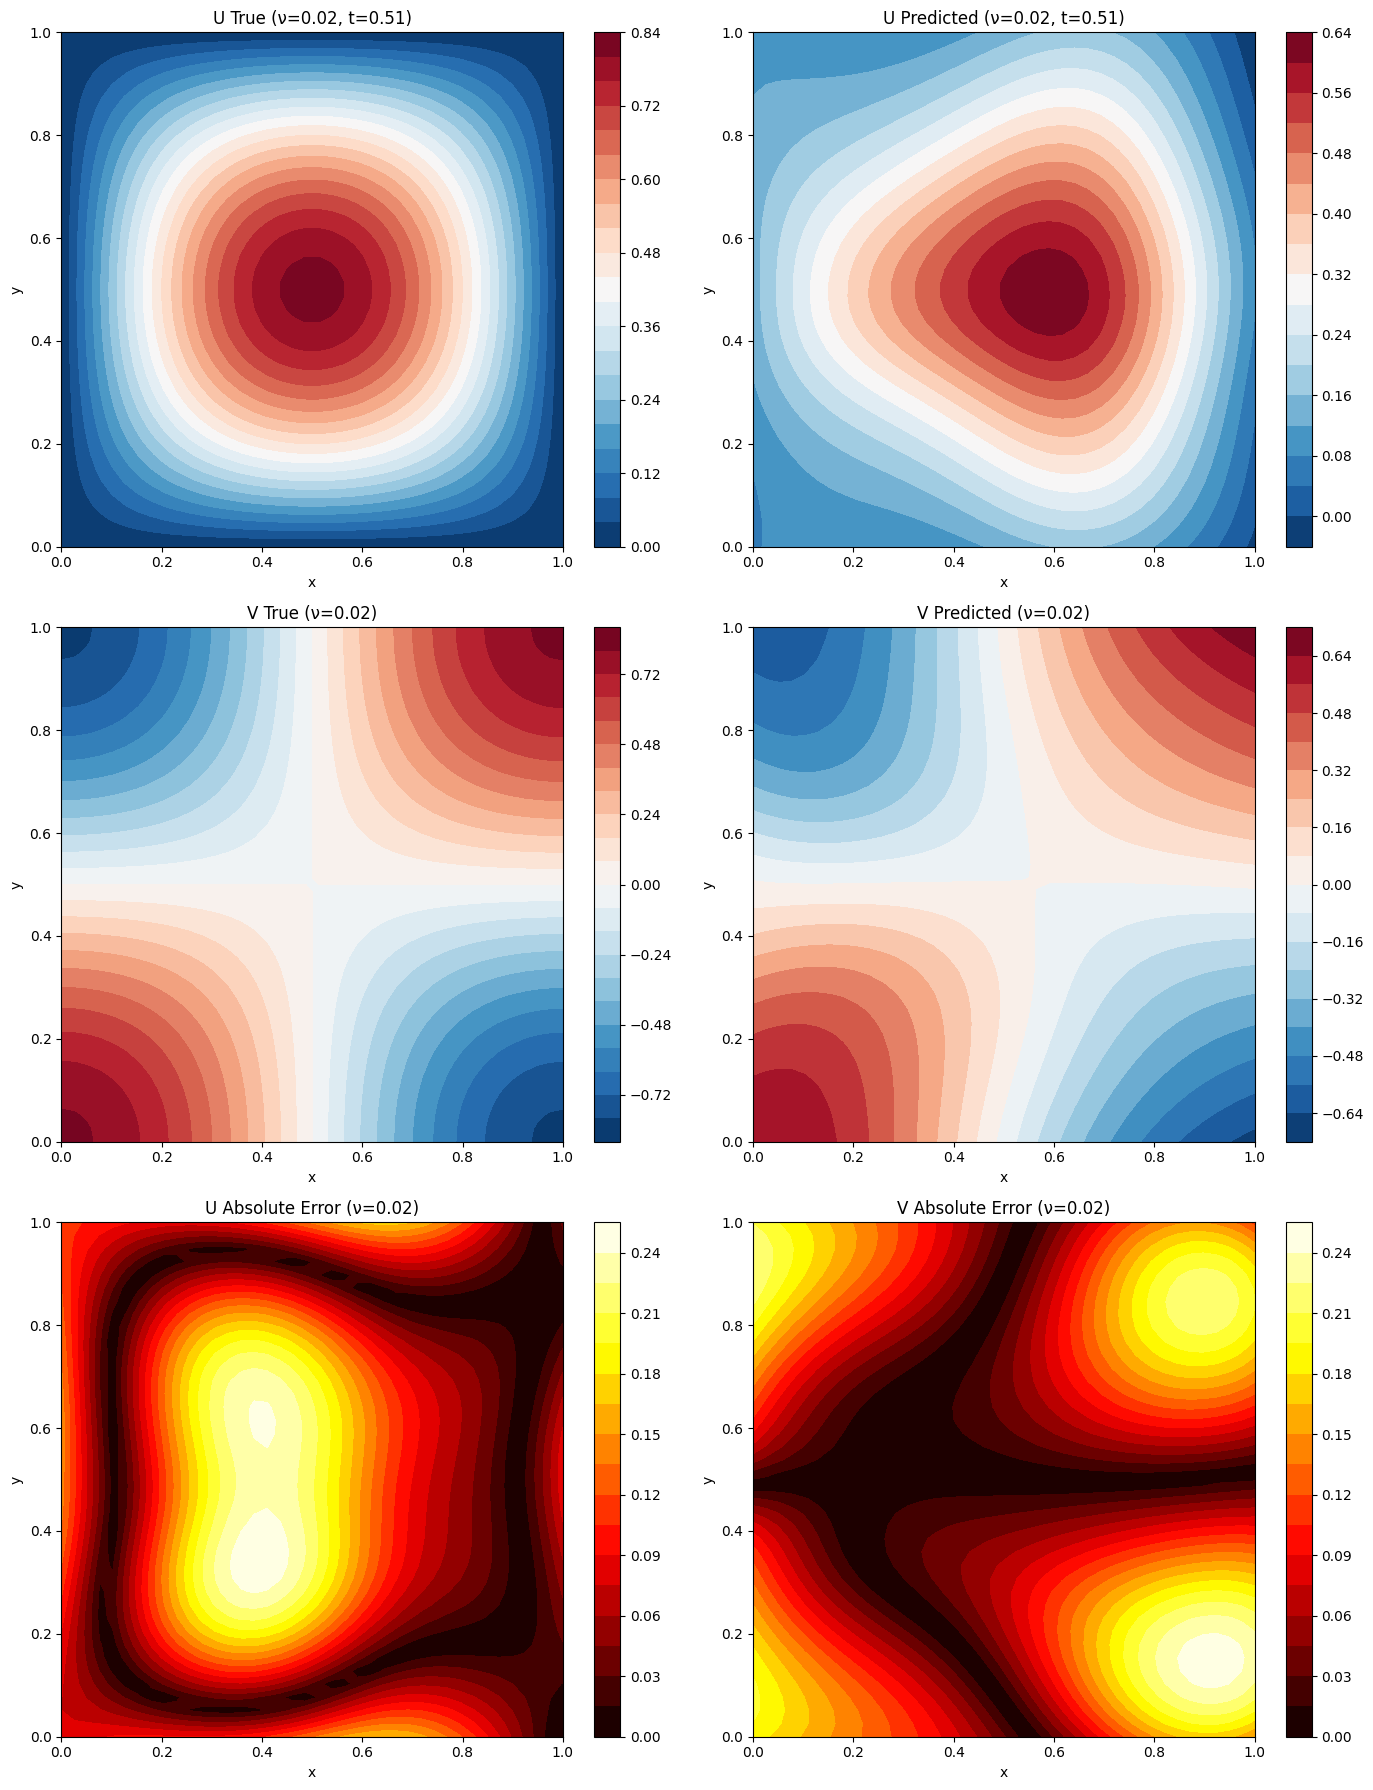


For ν=0.02:
  U - Max error: 0.251053, Mean error: 0.090923
  V - Max error: 0.249549, Mean error: 0.093292


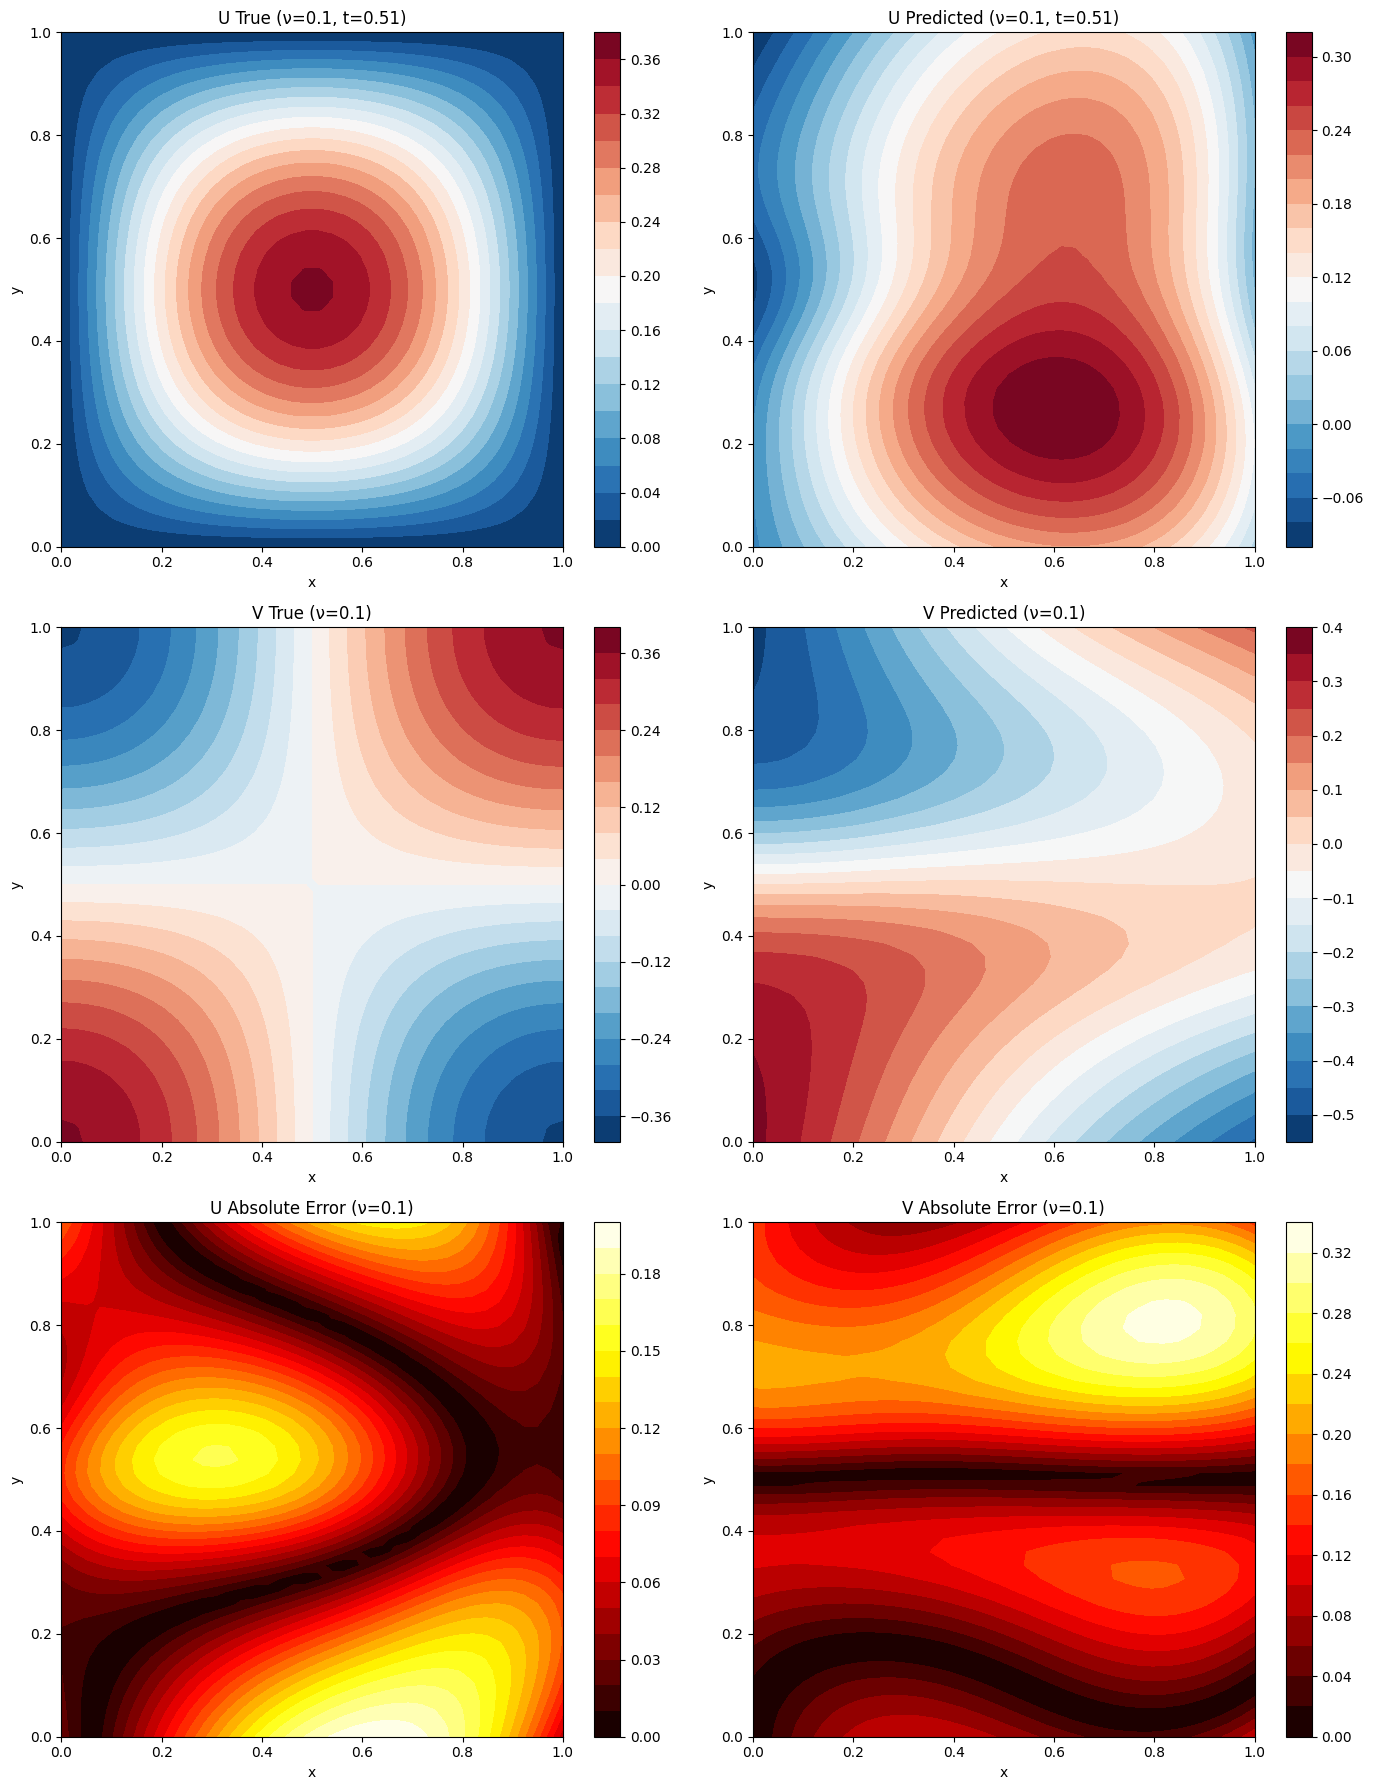


For ν=0.1:
  U - Max error: 0.198911, Mean error: 0.074527
  V - Max error: 0.327038, Mean error: 0.127178


In [28]:
results_no_noise = evaluate_model(
    trained_model, test_data, datasets, test_nu_values,
    x, y, t, device=device
)

## Adding Noise

In [31]:
def add_noise_to_dataset(datasets, noise_level=0.01):
    
    noisy_datasets = {}
    
    for nu, data in datasets.items():
        noisy_data = data.copy()
        
        # Add noise to u and v
        u_noise = np.random.normal(0, noise_level, data['u'].shape)
        v_noise = np.random.normal(0, noise_level, data['v'].shape)
        
        noisy_data['u'] = data['u'] + u_noise
        noisy_data['v'] = data['v'] + v_noise
    
        noisy_data['U'] = noisy_data['u'].reshape(data['U'].shape)
        noisy_data['V'] = noisy_data['v'].reshape(data['V'].shape)
        
        noisy_datasets[nu] = noisy_data
    
    return noisy_datasets


## Training with Noise

In [34]:
noise_level = 0.05  # 5% noise
noisy_datasets = add_noise_to_dataset(datasets, noise_level=noise_level)

# Create noisy train-test split
train_data_noisy, test_data_noisy = create_grouped_split(
    noisy_datasets,
    train_nu_values=train_nu_values,
    test_nu_values=test_nu_values,
    sample_fraction=0.3
)

# Initialize new model for noisy data
model_noisy = BurgersPINN(
    hidden_layers=[64, 64, 64, 64],
    activation='tanh'
)

trained_model_noisy, history_noisy = train_pinn(
    model=model_noisy,
    train_data=train_data_noisy,
    val_data=test_data_noisy,
    epochs=5000,
    lr=5e-4,  
    lambda_physics=2.0,
    print_every=500,
    device=device
)


Data Split Summary
Training nu values: [0.01, 0.05]
Testing nu values: [0.02, 0.1]
Training samples: 38400
Testing samples: 38400
Epoch 500/5000
  training  Loss: 0.098700 (data: 0.077938, Physics: 0.010381)
  Val Loss: 0.060994
  LR: 5.00e-04
Epoch 1000/5000
  training  Loss: 0.079250 (data: 0.065442, Physics: 0.006904)
  Val Loss: 0.056309
  LR: 5.00e-04
Epoch 1500/5000
  training  Loss: 0.071601 (data: 0.060939, Physics: 0.005331)
  Val Loss: 0.052404
  LR: 5.00e-04
Epoch 2000/5000
  training  Loss: 0.064540 (data: 0.056122, Physics: 0.004209)
  Val Loss: 0.050014
  LR: 5.00e-04
Epoch 2500/5000
  training  Loss: 0.060838 (data: 0.053822, Physics: 0.003508)
  Val Loss: 0.047482
  LR: 5.00e-04
Epoch 3000/5000
  training  Loss: 0.058225 (data: 0.051723, Physics: 0.003251)
  Val Loss: 0.046452
  LR: 5.00e-04
Epoch 3500/5000
  training  Loss: 0.056511 (data: 0.050625, Physics: 0.002943)
  Val Loss: 0.044984
  LR: 5.00e-04
Epoch 4000/5000
  training  Loss: 0.057446 (data: 0.051453, Physi

U velocity - MSE: 0.018759, MAE: 0.108314
V velocity - MSE: 0.024205, MAE: 0.123978


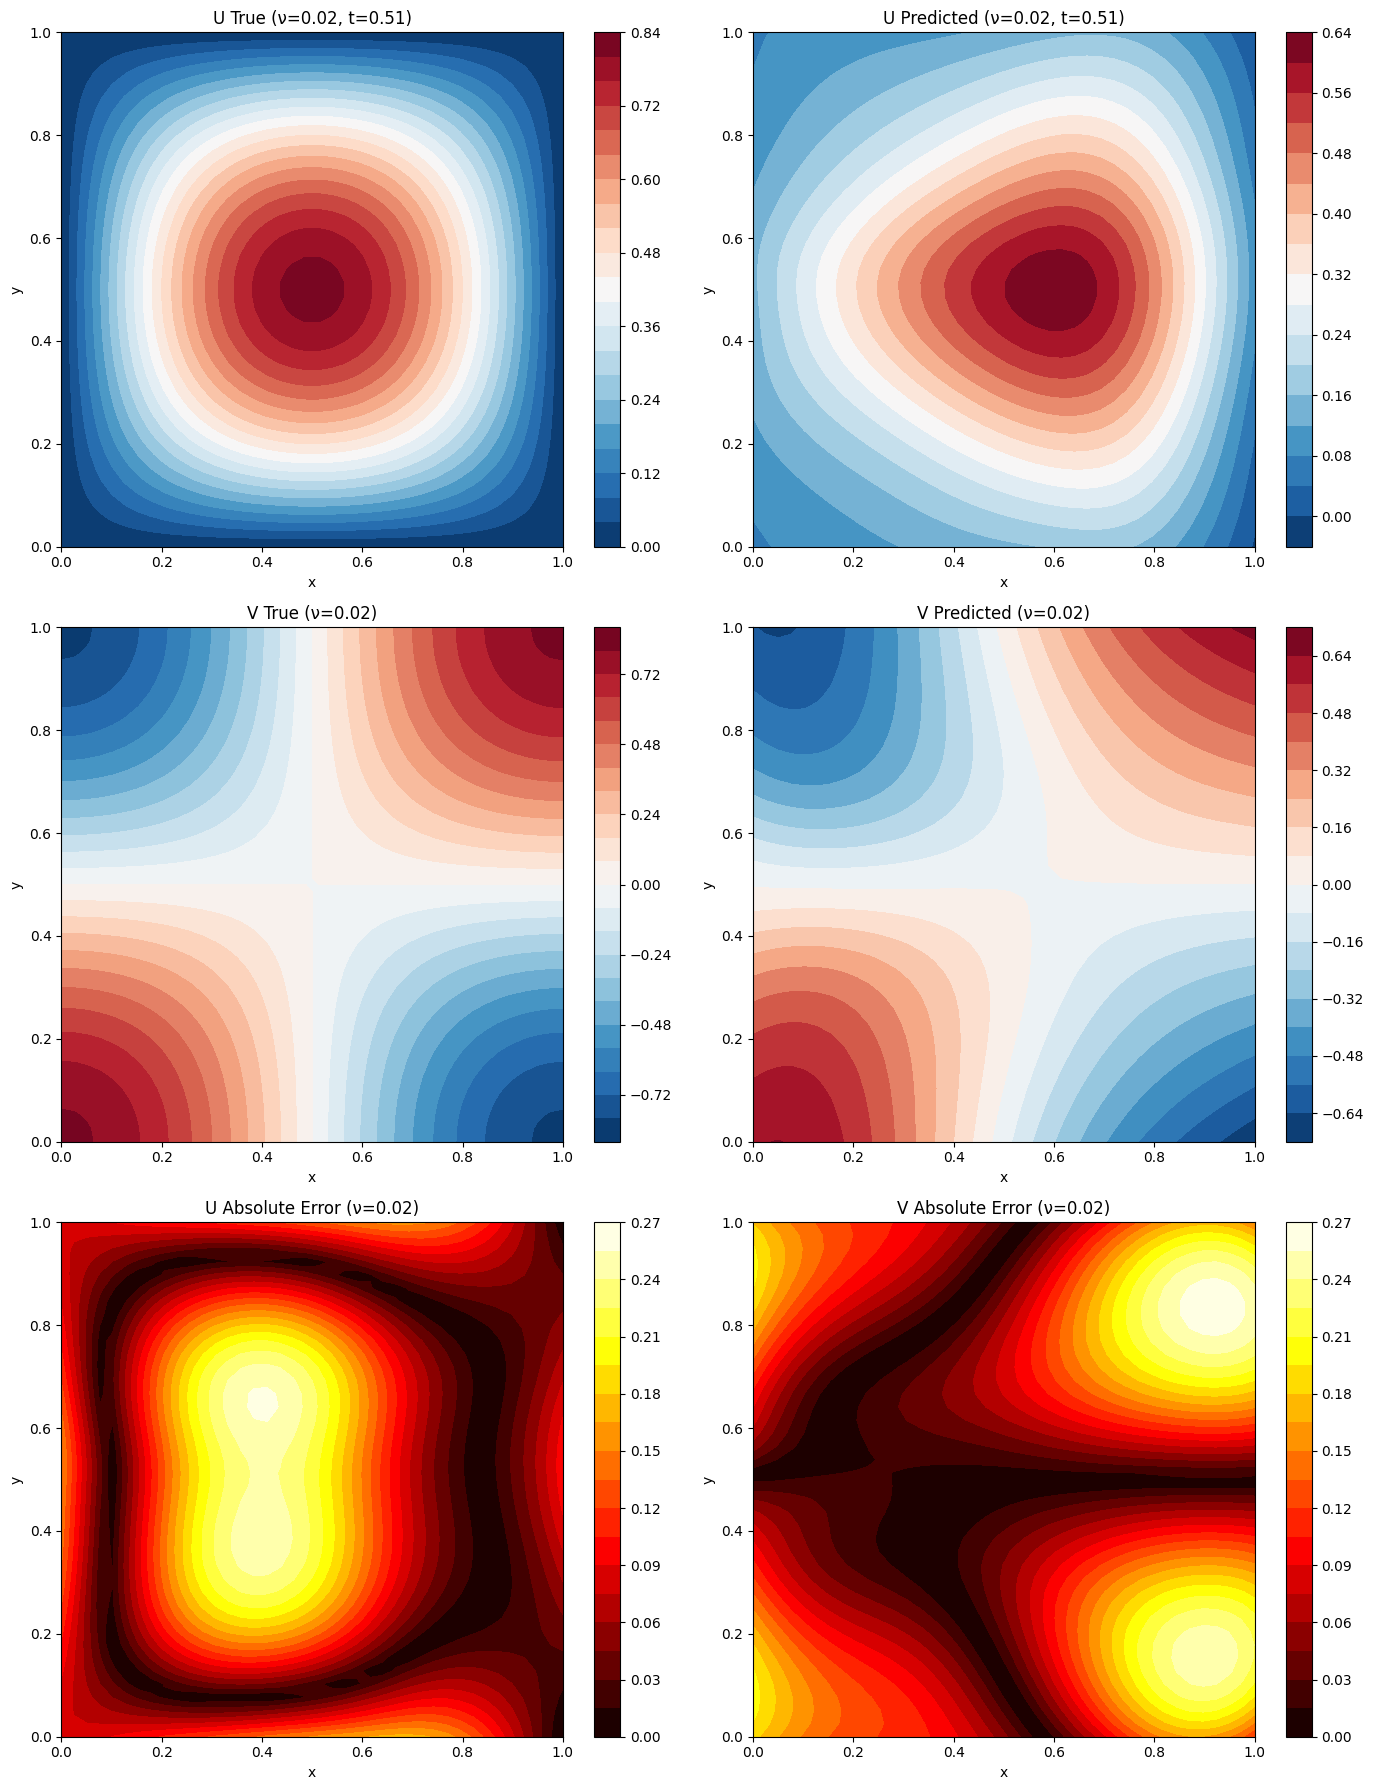


For ν=0.02:
  U - Max error: 0.257766, Mean error: 0.094003
  V - Max error: 0.264941, Mean error: 0.097413


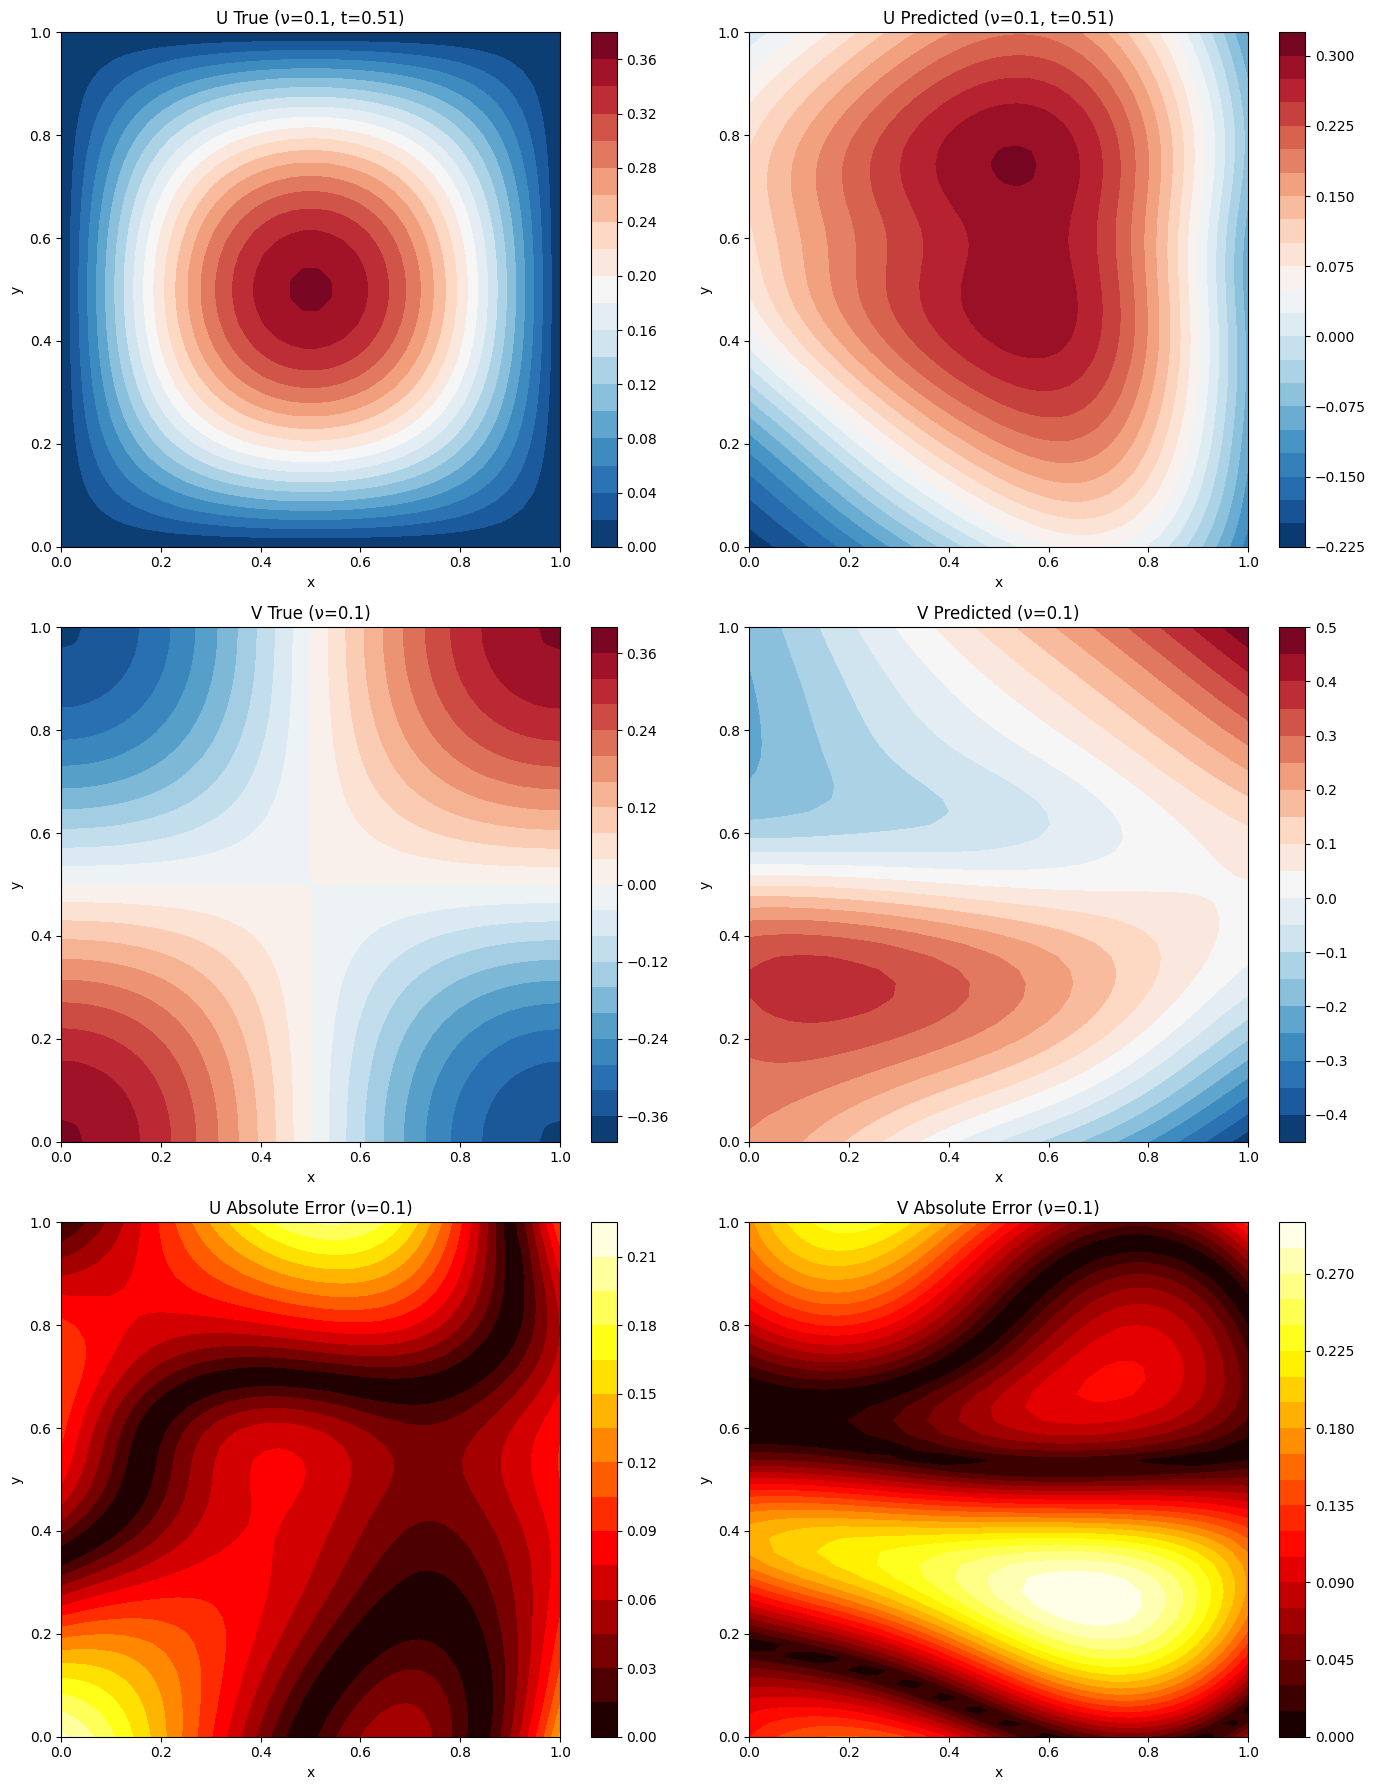


For ν=0.1:
  U - Max error: 0.213676, Mean error: 0.062937
  V - Max error: 0.299193, Mean error: 0.111529


In [35]:
results_noisy = evaluate_model(
    trained_model_noisy, test_data_noisy, datasets, test_nu_values,
    x, y, t, device=device
)
    